In [9]:
import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set the ticker symbol and date range
ticker = 'MSFT'  # Change this to any equity ticker symbol
start_date = '2019-01-01'
end_date = '2024-12-31'

# Download data from Yahoo Finance
equity_data = yf.download(ticker, start=start_date, end=end_date)
equity_prices = equity_data[['Close', 'Adj Close']]
equity_prices.to_csv(f'{ticker}_prices.csv')
print(f"{ticker} close and adjusted close price data from {start_date} to {end_date} saved to {ticker}_prices.csv")

# Load options data
df = pd.read_csv(f'option_{ticker}.csv')

# Remove rows where bid or ask price for calls or puts is zero
df = df[(df['bid'] > 0) & (df['ask'] > 0)]

# Separate calls and puts, merge them
calls = df[df['call_put'] == 'Call'].copy()
puts = df[df['call_put'] == 'Put'].copy()
calls.drop(columns=['call_put'], inplace=True)
puts.drop(columns=['call_put'], inplace=True)
calls.columns = ['date', 'act_symbol', 'expiration', 'strike'] + [col + '_call' for col in calls.columns[4:]]
puts.columns = ['date', 'act_symbol', 'expiration', 'strike'] + [col + '_put' for col in puts.columns[4:]]
merged_df = pd.merge(calls, puts, on=['date', 'act_symbol', 'expiration', 'strike'], how='outer')

# Filter rows where the difference in days between date and expiration is either 14 or 28 days
merged_df['date'] = pd.to_datetime(merged_df['date'])
merged_df['expiration'] = pd.to_datetime(merged_df['expiration'])
merged_df['days_to_expiration'] = (merged_df['expiration'] - merged_df['date']).dt.days
merged_df = merged_df[merged_df['days_to_expiration'].isin([14, 28])]

# Load equity prices data
equity_prices_path = f'{ticker}_prices.csv'
equity_prices = pd.read_csv(equity_prices_path)

# Preprocessing function
def preprocess_data(equity_close, equity_straddle_data):
    equity_close['Date'] = pd.to_datetime(equity_close['Date'])
    equity_straddle_data['date'] = pd.to_datetime(equity_straddle_data['date'])
    equity_straddle_data['expiration'] = pd.to_datetime(equity_straddle_data['expiration'])
    equity_close = equity_close.sort_values(by='Date')
    equity_straddle_data = equity_straddle_data.sort_values(by=['date', 'expiration'])
    return equity_close, equity_straddle_data

# Add close prices
def add_close_prices(equity_prices, equity_straddle_data):
    equity_straddle_data = equity_straddle_data.sort_values(by='date')
    equity_straddle_data = pd.merge_asof(equity_straddle_data, equity_prices[['Date', 'Close']], 
                                         left_on='date', right_on='Date', direction='backward')
    equity_straddle_data.rename(columns={'Close': 'current_close', 'Date': 'current_date'}, inplace=True)
    
    equity_straddle_data = equity_straddle_data.sort_values(by='expiration')
    equity_straddle_data = pd.merge_asof(equity_straddle_data, equity_prices[['Date', 'Close']], 
                                         left_on='expiration', right_on='Date', direction='backward')
    equity_straddle_data.rename(columns={'Close': 'expiration_close', 'Date': 'expiration_date'}, inplace=True)
    
    equity_straddle_data.drop(columns=['current_date', 'expiration_date'], inplace=True)
    
    return equity_straddle_data

# Calculate straddle prices
def calculate_straddle_prices(equity_straddle_data):
    equity_straddle_data['mid_call'] = (equity_straddle_data['bid_call'] + equity_straddle_data['ask_call']) / 2
    equity_straddle_data['mid_put'] = (equity_straddle_data['bid_put'] + equity_straddle_data['ask_put']) / 2
    equity_straddle_data['straddle_price'] = equity_straddle_data['mid_call'] + equity_straddle_data['mid_put']
    equity_straddle_data['straddle_delta'] = equity_straddle_data['delta_call'] + equity_straddle_data['delta_put']
    return equity_straddle_data

# Calculate delta neutralized returns
def calculate_delta_neutralized_returns(equity_straddle_data):
    equity_straddle_data = equity_straddle_data[equity_straddle_data['straddle_price'] != 0]
    
    results = []
    for _, row in equity_straddle_data.iterrows():
        initial_straddle_price = row['straddle_price']
        initial_delta = row['straddle_delta']
        initial_underlying_price = row['current_close']
        final_underlying_price = row['expiration_close']
        strike_price = row['strike']
        
        intrinsic_value_call = max(0, final_underlying_price - strike_price)
        intrinsic_value_put = max(0, strike_price - final_underlying_price)
        
        final_straddle_payoff = intrinsic_value_call + intrinsic_value_put
        underlying_price_change = final_underlying_price - initial_underlying_price
        
        delta_neutralized_return = (
            (final_straddle_payoff - initial_straddle_price)
            - (initial_delta * underlying_price_change)
        ) / initial_straddle_price
        results.append(delta_neutralized_return)
    
    equity_straddle_data = equity_straddle_data.copy()
    equity_straddle_data['delta_neutral_long_straddle_returns'] = results
    return equity_straddle_data

# Preprocess data
equity_prices, merged_df = preprocess_data(equity_prices, merged_df)
merged_df = add_close_prices(equity_prices, merged_df)
merged_df = calculate_straddle_prices(merged_df)
merged_df = calculate_delta_neutralized_returns(merged_df)

# Load volatility data
vol_data_path = 'vol_data.csv'
vol_df = pd.read_csv(vol_data_path)

# Filter volatility data for the chosen equity
vol_df = vol_df[vol_df['act_symbol'] == ticker]

vol_df['date'] = pd.to_datetime(vol_df['date'])
merged_df = pd.merge(merged_df, vol_df, on='date', how='left')

merged_df.drop(columns=['act_symbol_y'], inplace=True)
merged_df.rename(columns={'act_symbol_x': 'act_symbol'}, inplace=True)

# Convert returns to percentages
merged_df['delta_neutral_long_straddle_returns'] *= 100

# Calculate mean daily delta neutral long straddle returns
merged_df['mean_daily_delta_neutral_long_straddle_returns'] = (
    merged_df['delta_neutral_long_straddle_returns'] / merged_df['days_to_expiration']
)

# Drop rows with NA values
merged_df.dropna(inplace=True)

# Save the final DataFrame to a CSV file
output_path = f'{ticker}_final_straddle_data.csv'
merged_df.to_csv(output_path, index=False)

# Reorder columns
if 'delta_neutral_long_straddle_returns' in merged_df.columns:
    cols = [col for col in merged_df.columns if col not in ['delta_neutral_long_straddle_returns', 'mean_daily_delta_neutral_long_straddle_returns']]
    cols.append('delta_neutral_long_straddle_returns')
    cols.append('mean_daily_delta_neutral_long_straddle_returns')
    merged_df = merged_df[cols]

# Display the first 50 rows
merged_df.head(50)


[*********************100%%**********************]  1 of 1 completed


MSFT close and adjusted close price data from 2019-01-01 to 2024-12-31 saved to MSFT_prices.csv


,date,act_symbol,expiration,strike,bid_call,ask_call,vol_call,delta_call,gamma_call,theta_call,...,hv_year_low_date,iv_current,iv_week_ago,iv_month_ago,iv_year_high,iv_year_high_date,iv_year_low,iv_year_low_date,delta_neutral_long_straddle_returns,mean_daily_delta_neutral_long_straddle_returns
23,2020-01-10,MSFT,2020-01-24,145.0,15.40,17.85,0.2407,0.9894,0.0037,-0.0143,...,2019-12-13,0.2210,0.2215,0.1673,0.3298,2019-01-14,0.1459,2019-11-14,-1.875000,-0.133929
25,2020-01-10,MSFT,2020-01-24,155.0,6.20,7.05,0.1518,0.9171,0.0319,-0.0328,...,2019-12-13,0.2210,0.2215,0.1673,0.3298,2019-01-14,0.1459,2019-11-14,1.396392,0.099742
26,2020-01-10,MSFT,2020-01-24,157.5,4.65,4.80,0.1782,0.7663,0.0544,-0.0672,...,2019-12-13,0.2210,0.2215,0.1673,0.3298,2019-01-14,0.1459,2019-11-14,1.059744,0.075696
27,2020-01-10,MSFT,2020-01-24,167.5,0.28,0.33,0.1602,0.1234,0.0403,-0.0378,...,2019-12-13,0.2210,0.2215,0.1673,0.3298,2019-01-14,0.1459,2019-11-14,-29.325500,-2.094679
28,2020-01-10,MSFT,2020-01-24,150.0,11.25,12.00,0.2407,0.9434,0.0150,-0.0375,...,2019-12-13,0.2210,0.2215,0.1673,0.3298,2019-01-14,0.1459,2019-11-14,-0.397828,-0.028416
29,2020-01-10,MSFT,2020-01-24,172.5,0.06,0.07,0.1784,0.0301,0.0121,-0.0140,...,2019-12-13,0.2210,0.2215,0.1673,0.3298,2019-01-14,0.1459,2019-11-14,-1.232894,-0.088064
30,2020-01-10,MSFT,2020-01-24,165.0,0.68,0.77,0.1589,0.2469,0.0629,-0.0585,...,2019-12-13,0.2210,0.2215,0.1673,0.3298,2019-01-14,0.1459,2019-11-14,-61.615090,-4.401078
31,2020-01-10,MSFT,2020-01-24,162.5,1.43,1.56,0.1564,0.4218,0.0792,-0.0722,...,2019-12-13,0.2210,0.2215,0.1673,0.3298,2019-01-14,0.1459,2019-11-14,-20.158358,-1.439883
34,2020-01-17,MSFT,2020-01-31,150.0,16.05,18.80,0.3404,0.9518,0.0090,-0.0464,...,2019-12-13,0.2190,0.2210,0.1545,0.3128,2019-10-02,0.1459,2019-11-14,-1.401711,-0.100122
35,2020-01-17,MSFT,2020-01-31,155.0,11.25,13.10,0.3038,0.9040,0.0171,-0.0669,...,2019-12-13,0.2190,0.2210,0.1545,0.3128,2019-10-02,0.1459,2019-11-14,0.517120,0.036937


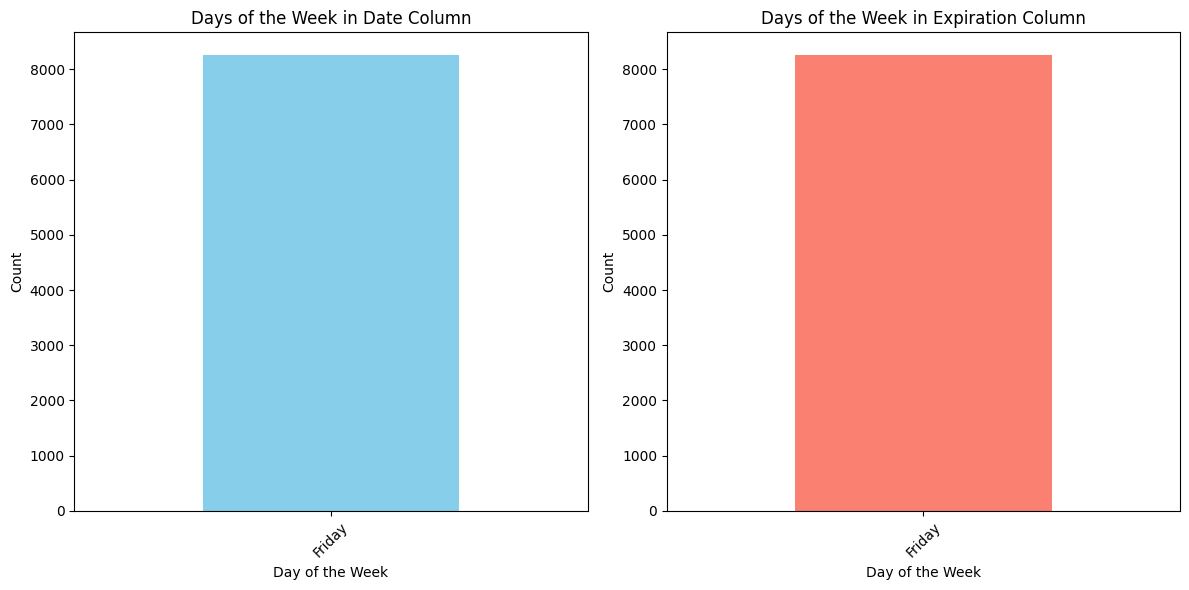

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming merged_df is already loaded
# Load the data if not already loaded (uncomment the line below if needed)
# merged_df = pd.read_csv('path_to_merged_df.csv')

# Convert the 'date' and 'expiration' columns to datetime if not already
merged_df['date'] = pd.to_datetime(merged_df['date'])
merged_df['expiration'] = pd.to_datetime(merged_df['expiration'])

# Extract the day of the week
merged_df['date_day_of_week'] = merged_df['date'].dt.day_name()
merged_df['expiration_day_of_week'] = merged_df['expiration'].dt.day_name()

# Count the occurrences of each day of the week
date_day_counts = merged_df['date_day_of_week'].value_counts().sort_index()
expiration_day_counts = merged_df['expiration_day_of_week'].value_counts().sort_index()

# Plot the counts
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
date_day_counts.plot(kind='bar', color='skyblue')
plt.title('Days of the Week in Date Column')
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
expiration_day_counts.plot(kind='bar', color='salmon')
plt.title('Days of the Week in Expiration Column')
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

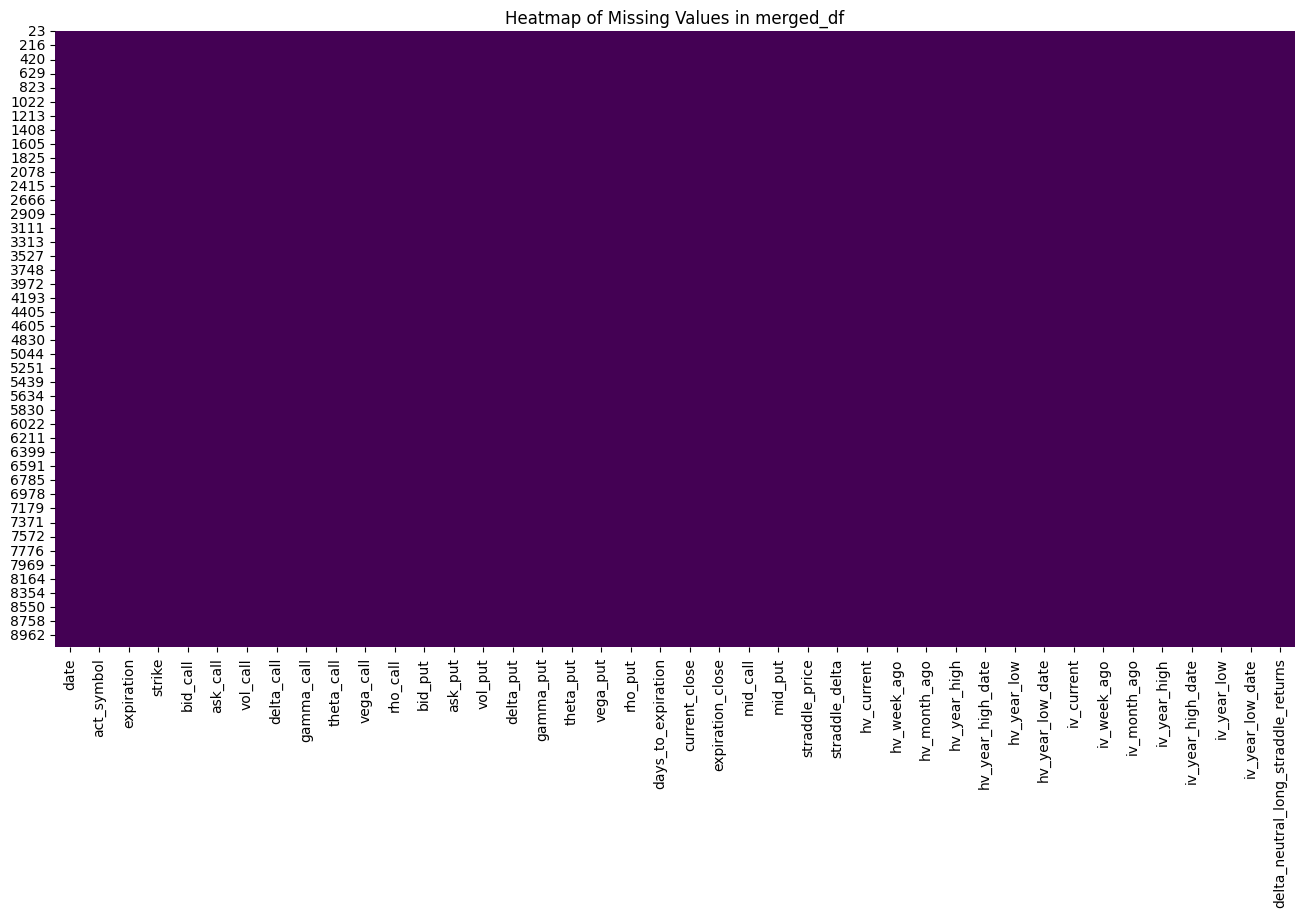

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
sns.heatmap(merged_df.isna(), cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Values in merged_df')
plt.show()

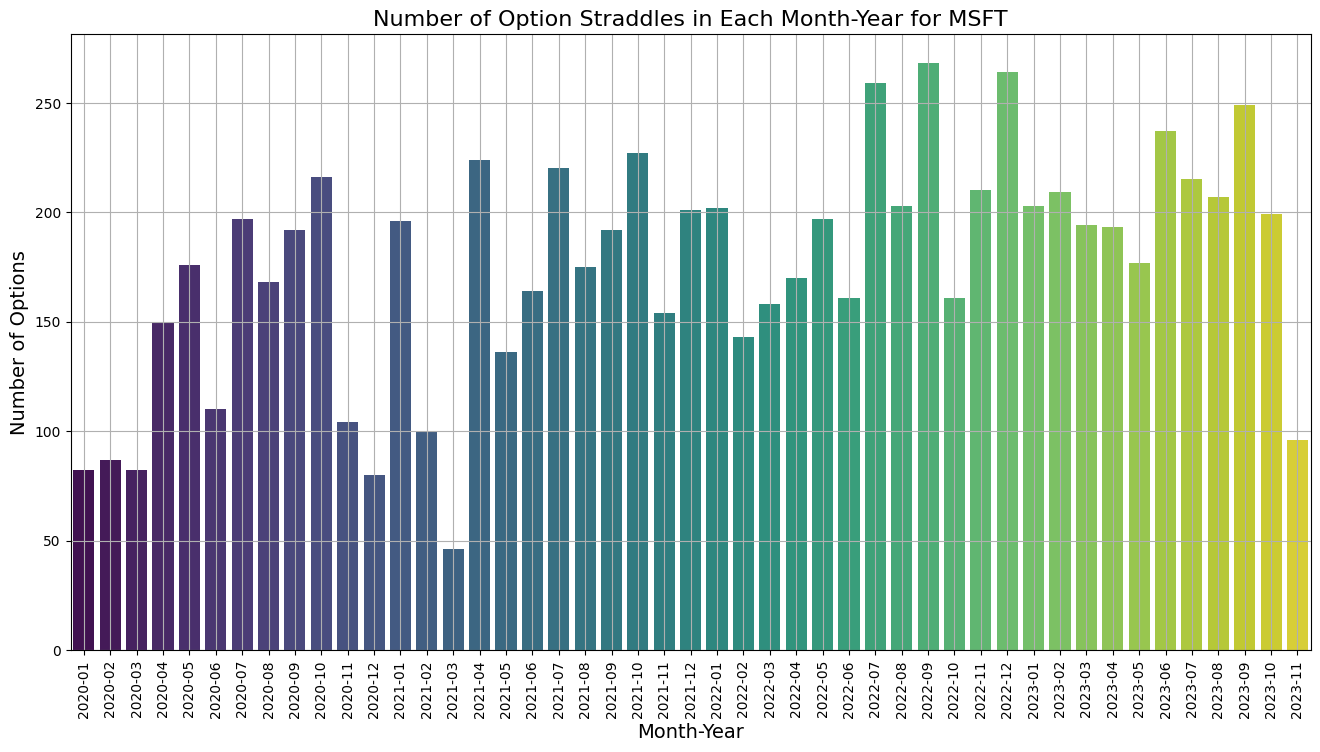

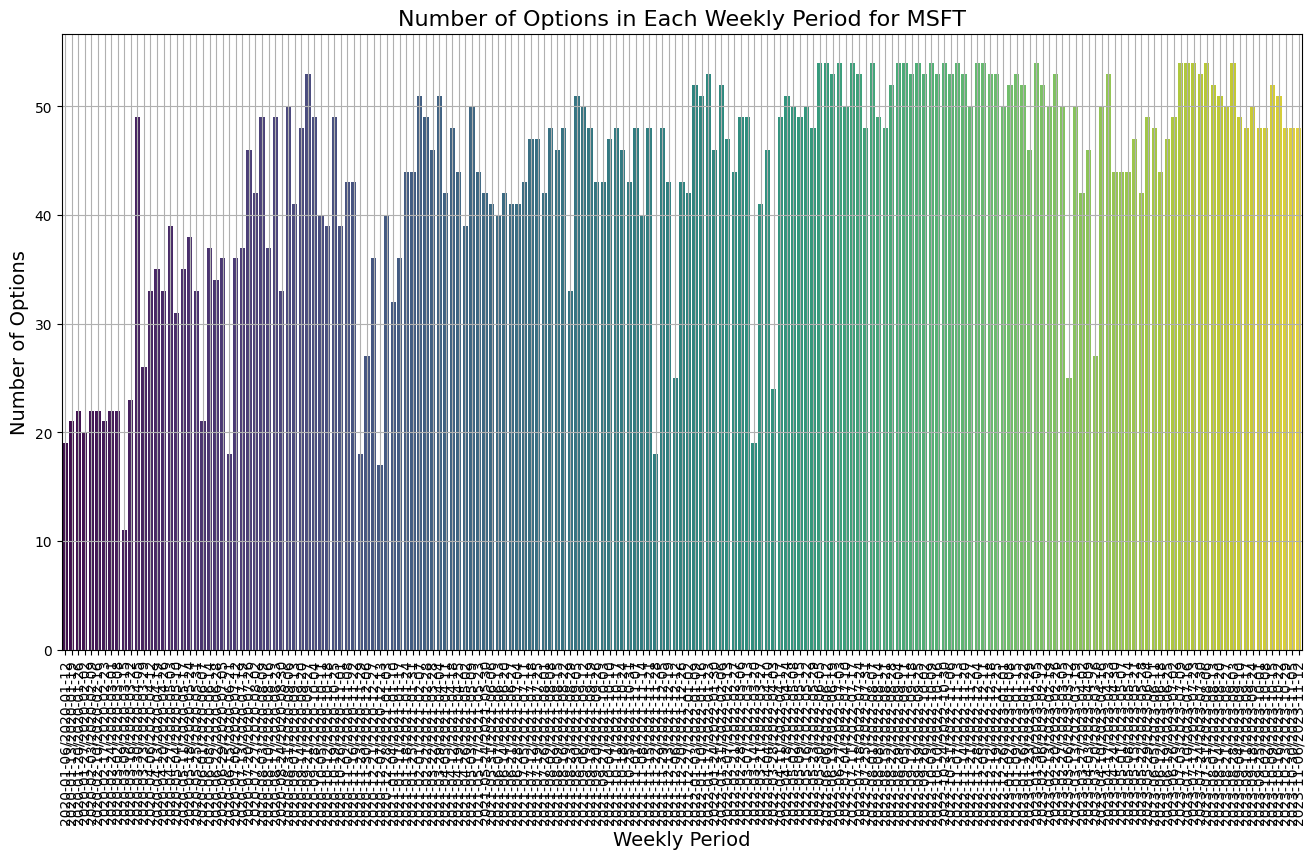

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming merged_df is already loaded

# Convert 'date' to datetime if not already
merged_df['date'] = pd.to_datetime(merged_df['date'])

# Create a new column for month-year
merged_df['month_year'] = merged_df['date'].dt.to_period('M')

# Plot number of options in each month-year combination
plt.figure(figsize=(16, 8))
sns.countplot(data=merged_df, x='month_year', palette='viridis')
plt.title(f'Number of Option Straddles in Each Month-Year for {ticker}', fontsize=16)
plt.xlabel('Month-Year', fontsize=14)
plt.ylabel('Number of Options', fontsize=14)
plt.xticks(rotation=90)
plt.grid(True)
plt.show()


# Create a new column for weekly periods
merged_df['weekly'] = merged_df['date'].dt.to_period('W')

# Plot number of options in each weekly period
plt.figure(figsize=(16, 8))
sns.countplot(data=merged_df, x='weekly', palette='viridis')
plt.title(f'Number of Option Straddles in Each Weekly Period for {ticker}', fontsize=16)
plt.xlabel('Weekly Period', fontsize=14)
plt.ylabel('Number of Options', fontsize=14)
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

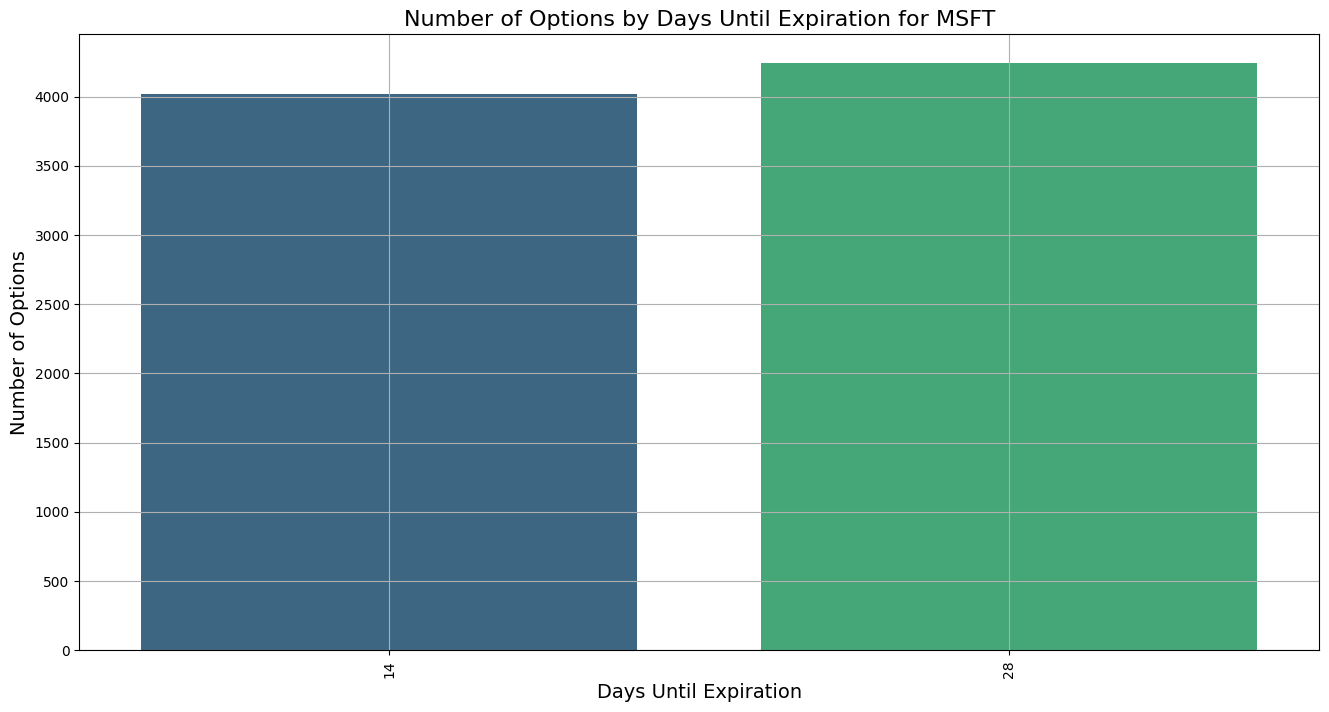

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert 'date' and 'expiration' to datetime if not already
merged_df['date'] = pd.to_datetime(merged_df['date'])
merged_df['expiration'] = pd.to_datetime(merged_df['expiration'])

# Calculate the difference in days between 'expiration' and 'date'
merged_df['days_until_expiration'] = (merged_df['expiration'] - merged_df['date']).dt.days

# Plot the number of rows for each unique difference in days until expiration
plt.figure(figsize=(16, 8))
sns.countplot(data=merged_df, x='days_until_expiration', palette='viridis')
plt.title(f'Number of Options by Days Until Expiration for {ticker}', fontsize=16)
plt.xlabel('Days Until Expiration', fontsize=14)
plt.ylabel('Number of Options', fontsize=14)
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

In [7]:
import numpy as np

# Count NA values
na_counts = merged_df.isna().sum()
print("Number of NA values in each column:")
print(na_counts)

# Count positive infinity values in 'delta_neutral_long_straddle_returns'
pos_inf_count = np.isposinf(merged_df['delta_neutral_long_straddle_returns']).sum()
print("\nNumber of positive infinity values in 'delta_neutral_long_straddle_returns':")
print(pos_inf_count)

# Count negative infinity values in 'delta_neutral_long_straddle_returns'
neg_inf_count = np.isneginf(merged_df['delta_neutral_long_straddle_returns']).sum()
print("\nNumber of negative infinity values in 'delta_neutral_long_straddle_returns':")
print(neg_inf_count)

# Total number of rows
num_rows = merged_df.shape[0]
print("\nNumber of rows in merged_df:")
print(num_rows)

Number of NA values in each column:
date                                   0
act_symbol                             0
expiration                             0
strike                                 0
bid_call                               0
ask_call                               0
vol_call                               0
delta_call                             0
gamma_call                             0
theta_call                             0
vega_call                              0
rho_call                               0
bid_put                                0
ask_put                                0
vol_put                                0
delta_put                              0
gamma_put                              0
theta_put                              0
vega_put                               0
rho_put                                0
days_to_expiration                     0
current_close                          0
expiration_close                       0
mid_call             

/Users/matthewbellick/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


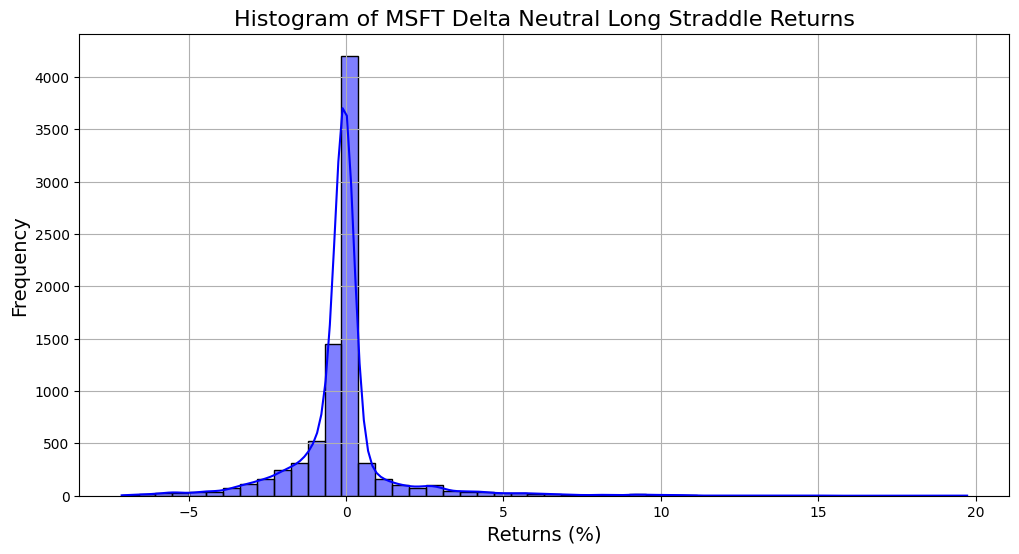

count    8254.000000
mean       -0.126719
std         1.687271
min        -7.130304
25%        -0.389185
50%        -0.054613
75%         0.024461
max        19.730735
Name: mean_daily_delta_neutral_long_straddle_returns, dtype: float64

In [12]:
plt.figure(figsize=(12, 6))
sns.histplot(merged_df['mean_daily_delta_neutral_long_straddle_returns'], bins=50, kde=True, color='blue')
plt.title(f'Histogram of {ticker} Delta Neutral Long Straddle Returns', fontsize=16)
plt.xlabel('Returns (%)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)
plt.show()

merged_df["mean_daily_delta_neutral_long_straddle_returns"].describe()